In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import ipywidgets as widgets

$$\text{Leaf}$$

In [88]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.leaf_label = None
        self.prediction = self.predict()

    def predict(self):
        if self.leaf_label is None:            
            classes = {}
            for label in self.labels:
                if label not in classes:
                    classes[label] = 1
                else:
                    classes[label] += 1
            self.leaf_label = max(classes, key=classes.get)    
        return self.leaf_label

$$\text{Node}$$

In [89]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


$$\text{Decision Tree}$$

In [90]:
class Decision_Tree_Classifier:
    def __init__(self, criterion='gini', max_depth = None, min_samples_leaf = 1,
                 min_impurity_decrease = 0.0, homogeneous_leaf = True):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.homogeneous_leaf = homogeneous_leaf
        self.current_depth = 0
        
    def informative_criteria(self, labels):
        classes = {}
        diff = 1e-17
        for label in labels:
            if label not in classes:
                classes[label] = 1
            else:
                classes[label] += 1
        
        if self.criterion == 'gini':            
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p**2            
        elif self.criterion == 'shenon':
            impurity = 0
            for label in classes:
                p = classes[label]/ len(labels)
                if p == 0:
                    p = diff
                impurity -= p * np.log2(p)
        return impurity
    
    def quality(self, left_labels, right_labels, current_information):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_information - p * self.informative_criteria(left_labels) - (1 - p) * self.informative_criteria(right_labels)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        
    def build_tree(self, data, labels):        
        quality, t, idx = self.find_best_split(data, labels)
        
        if quality == 0 or (len(set(labels)) == 1 and homogeneous_leaf):
            return Leaf(data, labels)
        
        self.current_depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
        
        if self.current_depth == self.max_depth:
            true_branch = Leaf(true_data, true_labels)
            false_branch = Leaf(false_data, false_labels)
            self.current_depth -= 1
            
        else:
            true_branch = self.build_tree(true_data, true_labels)
            false_branch = self.build_tree(false_data, false_labels)
        
        return Node(idx, t, true_branch, false_branch)
    
    def split(self, data, labels, idx, t):
        left_mask = data[:, idx] <= t
        
        true_data = data[left_mask]        
        true_labels = labels[left_mask]
        
        false_data = data[~left_mask]
        false_labels = labels[~left_mask]
        
        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):
        current_information = self.informative_criteria(labels)
        
        best_quality = 0
        best_t = None
        best_idx = None
        
        n_features = data.shape[1]
        
        for idx in range(n_features):
            t_values = np.unique(data[:, idx])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
                
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_information)
                
                if current_quality > best_quality and abs(current_quality - best_quality) > self.min_impurity_decrease:
                    best_quality, best_t, best_idx = current_quality, t, idx
                
        return best_quality, best_t, best_idx
    
    def classify_object(self, obj, node):
        if isinstance(node, Leaf):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def predict(self, data):
        classes = np.zeros(len(data))
        for i, obj in enumerate(data):
            classes[i] = self.classify_object(obj, self.tree)
        return classes
            

$$\text{Random Forest}$$

In [97]:
class RandomForest(Decision_Tree_Classifier):
    
    def __init__(self, n_tree = 1, criterion='gini', max_depth = None, min_samples_leaf = 1, min_impurity_decrease = 0.0, homogeneous_leaf = True):        
        super().__init__(criterion, max_depth, min_samples_leaf, min_impurity_decrease, homogeneous_leaf)
        self.n_tree = n_tree
        np.random.seed(42)
    
    
    def get_bootstrap(self, data, labels):
        n_samples = data.shape[0]
        bootstrap = []
        
        for i in range(self.n_tree):            
            sample_idxs = np.random.randint(0, n_samples, n_samples)
            b_data = data[sample_idxs]
            b_labels = labels[sample_idxs]
            bootstrap.append((b_data, b_labels, sample_idxs))
            
        return bootstrap
    
    
    def get_subsample(self, n_features):        
        sample_idxs = np.arange(0, n_features)
        np.random.shuffle(sample_idxs)
        
        subsample_len = int(np.sqrt(n_features))
        subsample = sample_idxs[:subsample_len]       
        
        return subsample     
     
        
    def find_best_split(self, data, labels):
        current_information = self.informative_criteria(labels)
        
        best_quality = 0
        best_t = None
        best_idx = None
        
        n_features = data.shape[1]
        
        subsample = self.get_subsample(n_features)
        
        for idx in subsample:
            t_values = np.unique(data[:, idx])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, idx, t)
                
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_information)
                
                if current_quality > best_quality and abs(current_quality - best_quality) > self.min_impurity_decrease:
                    best_quality, best_t, best_idx = current_quality, t, idx
                
        return best_quality, best_t, best_idx
    
    
    def fit(self, data, labels):
        self.forest = []
        for b_data, b_labels, idx in self.get_bootstrap(data, labels):
            self.forest.append([self.build_tree(b_data, b_labels), idx])
        self.forest = np.array(self.forest, dtype=object)
        
    def oob(self, data, labels, flag):
        """
        flag = 'train' или 'test'
        data - исходные данные
        """
        n_obj = data.shape[0]
        predictions = np.zeros(labels.shape[0])
        if flag == 'train':            
            for obj in range(n_obj):
                tmp_pred = []
                for tree, idx in self.forest:
                    if obj in idx:
                        tmp_pred.append(super().classify_object(data[obj], tree))
                if len(tmp_pred) < 1:
                    predictions[obj] = None
                else:
                    predictions[obj] = max(set(tmp_pred), key=tmp_pred.count)
                
        else:
            for obj in range(n_obj):
                tmp_pred = []
                for tree, idx in self.forest:
                    if obj not in idx:
                        tmp_pred.append(super().classify_object(data[obj], tree))
                if len(tmp_pred) < 1:
                    predictions[obj] = None
                else:
                    predictions[obj] = max(set(tmp_pred), key=tmp_pred.count)
        not_none_mask = predictions != None
        
        return sum(labels[not_none_mask] == predictions[not_none_mask])/sum(not_none_mask) * 100        
    
    def tree_vote(self, data):
        predictions = []
        for tree in self.forest[:, 0]:
            predictions.append(self.predict(data, tree))
            
        predictions = list(zip(*predictions))
        
        voted_predictions = np.array([])
        
        #сначала выполняется счёт количества голосов, потом выбор наибольшего
        for obj in predictions:
            voted_predictions = np.append(voted_predictions, max(set(obj), key=obj.count))
        return voted_predictions
    
    def predict(self, data, tree):
        classes = np.zeros(len(data))
        for i, obj in enumerate(data):
            classes[i] = self.classify_object(obj, tree)
        return classes
        

$$\text{Accuracy}$$

In [92]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

$$\text{Meshgrid}$$

In [93]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

### <b> Task №1

In [94]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [98]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                     classification_labels, 
                                                                     test_size = 0.3,
                                                                     random_state = 1)

global train_data, train_labels, test_data, test_labels

In [102]:
def plot_hp_trees(n_trees = 1, max_depth = 3, min_samples_leaf = 5, criterion = 'gini'):
    my_forest = RandomForest(n_trees, criterion, max_depth, min_samples_leaf)
    my_forest.fit(train_data, train_labels)
    
    train_answers = my_forest.tree_vote(train_data)
    test_answers = my_forest.tree_vote(test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    plt.figure(figsize = (20, 7))
    
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(my_forest.tree_vote(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}, n_trees = {n_trees}, max_d = {max_depth}, min_s = {min_samples_leaf}, cr = {criterion}')

    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}, n_trees = {n_trees}, max_d = {max_depth}, min_s = {min_samples_leaf}, cr = {criterion}')
    plt.show()
    
widgets.interact(plot_hp_trees, n_trees = (1, 250, 1), max_depth = (3, 15, 1), min_samples_leaf = (1, 20, 1), criterion = ['gini', 'shenon']);
    
    
    

interactive(children=(IntSlider(value=1, description='n_trees', max=250, min=1), IntSlider(value=3, descriptio…

* Можно заключить, что ситуация с переобучением действительно редкость для случайного леса (переобучение можно увидеть при параметрах <b>n_trees</b> = 8, <b>max_depth</b> = 3, <b>min_samples_leaf</b> = 1, <b>criterion</b> = 'gini')
* При увеличении параметра <b>n_trees</b> можно увидеть флуктуации метрики (на графиках ниже), но чем больше этот параметр, тем все реже эти колебания происходят.

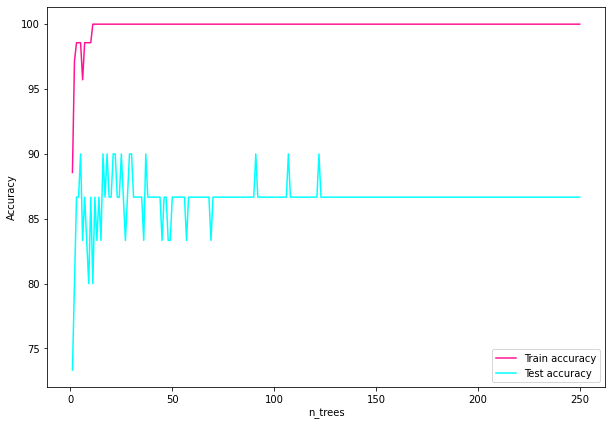

In [54]:
N = 250
accuracy_train_list = np.zeros(N)
accuracy_test_list = np.zeros(N)
for n_trees in range(1, N+1):
    my_forest = RandomForest(n_trees)
    my_forest.fit(train_data, train_labels)
    
    train_answers = my_forest.tree_vote(train_data)
    test_answers = my_forest.tree_vote(test_data)
    
    accuracy_train_list[n_trees-1] = accuracy_metric(train_labels, train_answers)
    accuracy_test_list[n_trees-1] = test_accuracy = accuracy_metric(test_labels, test_answers)
    
plt.figure(figsize = (10, 7))
plt.plot(np.arange(1, N+1), accuracy_train_list, label = 'Train accuracy', color = '#FF1493')
plt.plot(np.arange(1, N+1), accuracy_test_list, label = 'Test accuracy', color = '#00FFFF')

plt.xlabel('n_trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    

### <b> Task №2

In [82]:
n_trees = 10
my_forest = RandomForest(10)
my_forest.fit(classification_data, classification_labels)

In [83]:

train_accuracy = my_forest.oob(classification_data, classification_labels, 'train')
test_accuracy = my_forest.oob(classification_data, classification_labels, 'test')

print(train_accuracy, test_accuracy)

100.0 88.0


In [84]:
train_accuracy

100.0

In [85]:
test_accuracy

88.0